<a href="https://colab.research.google.com/github/Rx4M00N/IA_Tarea1/blob/main/CNN_Conjunto_de_autores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red convolucional CNN con conjuntos dados

Se comienza llamando a las librerías a usar

In [ ]:
#Importació de las librerías requeridas
#Librerías para cálculos, operaciones y gráficas 
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
%matplotlib inline

#Librerías para el uso de redes de inteligencia artificial de Tensorflow
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img ,img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing import image 
import warnings
warnings.filterwarnings('ignore')

## Importación de los datos

Se accede a los datos que se encuentran en una carpeta de drive en el siguiente enlace: https://drive.google.com/drive/folders/1GzGk-ubFXignld_Nh3PC0YftqUZuZBEb?usp=sharing 

Para poder ejecutarlo correctamente es necesario colocar esa carpeta en "Mi unidad" de google drive como un acceso directo

In [ ]:
#Librería para acceder a google drive
from google.colab import drive
#Se accede a los documentos desde Google Drive
drive.mount('/content/gdrive')

#Se extraen los archivos del .zip guardado en drive
my_data_dir = !unzip gdrive/My\ Drive/data/casting_data.zip > /dev/null

Mounted at /content/gdrive


In [ ]:
#Se establece una ruta para la carpeta descomprimida de drive
my_data_dir = 'casting_data/'

In [ ]:
#Se establece la ruta a las carpetas con los datos de entrenamiento y de prueba
train_path = my_data_dir + 'train/'
test_path = my_data_dir + 'test/'

#Creación de 2 parámetros de la red, donde se da la información como el tamaño de pixeles de la imágen
image_shape = (300,300,1)
batch_size = 32 #Se ajusta en realción a los y el tipo de problema

In [ ]:
#Se muestra la cantidad de piezas etiquetadas como defectuosas y como buenas en el subconjunto de entrenamiento/train
print("Cantidad de piezas de train buenas ok_front:",len(os.listdir(train_path+'ok_front')))
print("Cantidad de piezas de train malas def_front:",len(os.listdir(train_path+'def_front')))

Cantidad de piezas de train buenas ok_front: 2875
Cantidad de piezas de train malas def_front: 3758


In [ ]:
#Se muestra la cantidad de piezas etiquetadas como defectuosas y como buenas en el subconjunto de prueba/test
print("Cantidad de piezas de test buenas ok_front:",len(os.listdir(test_path+'ok_front')))
print("Cantidad de piezas de test malas def_front:",len(os.listdir(test_path+'def_front')))

Cantidad de piezas de test buenas ok_front: 262
Cantidad de piezas de test malas def_front: 453


In [ ]:
# Se normaliza la imágen escalando los valores a grises y así tener solo una clase
image_gen = ImageDataGenerator(rescale=1/255)

## Preparación de los datos

Se preparan los datos para poder ser utilizados por la red, la forma en la que se va a realizar es por medio de si pertenece o no a cierta categoría, para este conjunto de datos solo se disponen de dos categorías, por lo que se puede evaluar de manera binaria a si pertenece o no a esa categoría. Cade recordar que las imágenes usadas se encuentran en escala de grises y se analizan de n paquetes de 32 antes de realizar un cambio.

In [ ]:
#Preparación de los datos de entrenamiento
train_set = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode="grayscale",
                                               batch_size=batch_size,            #Tamaño de los paquetes que se analizan
                                               class_mode='binary',shuffle=True) #Establece que va a ser de manera binaria, asigna 0 a defectuosa y 1 a buena

#Preparación de los datos de prueba
test_set = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode="grayscale",
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 6633 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [ ]:
#Se usa para demostrar que las piezas defectuosas son tomadas como 0 y las buenas como 1
train_set.class_indices

{'def_front': 0, 'ok_front': 1}

## Creación del modelo convolucional

Se crea el modelo convolucional donde se definen características como cantidad de filtros, tamaño del kernel por capa, tamaño del pooling y otros hiperparámetros como el stride o el zero padding, en esta sección también se crea la red densa de clasificación que se ubica al final de la CNN.

Para su elaboración se hizo de manera secuencial 3 ciclos de convolucional y de pooling y una única capa oculta.

In [ ]:
#Creación del modelo CNN
#Se crea una secuencia, la cual es una función de tensorflow
model = Sequential()

#Primeras capas, una convolucional y otra de pooling para reducir
#Se puede cambiar la cantidad de filtros, el tamaño del kernel, el valor del stride (salto), la existencia o no del padding
#Se introduce en tamaño de la imagen (300x300) y la función de activación,la cual es una reLu.
model.add(Conv2D(filters=8, kernel_size=(3,3), strides=(1, 1), padding="valid", input_shape=image_shape, activation='relu',)) #Ciclo 1, kernel 3x3
model.add(MaxPooling2D(pool_size=(2, 2)))

#Segunda capa, una convolucional y otra de pooling para reducir
model.add(Conv2D(filters=16, kernel_size=(3,3), strides=(1, 1), padding="valid", input_shape=image_shape, activation='relu',)) #Ciclo 2, kernel 3x3
model.add(MaxPooling2D(pool_size=(2, 2)))

#Tercera capa, una convolucional y otra de pooling para reducir
model.add(Conv2D(filters=16, kernel_size=(3,3), strides=(1, 1), padding="valid", input_shape=image_shape, activation='relu',)) #Ciclo 3, kernel 3x3
model.add(MaxPooling2D(pool_size=(2, 2)))

#Al finalizar el proceso se pasa por una etápa de flattering para acondicionar los datos para la red de clasificación
model.add(Flatten())

#Comienzo de la red densa de clasificación

model.add(Dense(75))              #75 neuronas en una capa
model.add(Activation('sigmoid'))   #Función de activación de tipo sigmpoide debido a que es densa
#model.add(Dropout(0.5))

# Última capa, salida de la red
model.add(Dense(1, activation='sigmoid'))  #Se establece una neurona de saldia debido a la elección de categoría binaria

model.compile(loss='binary_crossentropy',  #Red densa de clasificación
              optimizer='adam',
              metrics=['accuracy'])
#Early_stop monitorea la pérdida obtenida y si empieza a ver que se estanca detiene el entrenamiento
early_stop = EarlyStopping(monitor='loss',patience=2) 

Luego de crear el modelo se procede a entrenarlo, para ello se usa el conjunto de datos de entrenamiento y se corre por 20 iteraciones o hasta que el early_stop decida detener el entrenamiento

In [ ]:
#Entrenamiento de la red CNN
results = model.fit_generator(train_set,epochs=20,
                              validation_data=test_set,
                             callbacks=[early_stop])

Epoch 1/20
208/208 [==============================] - 17s 77ms/step - loss: 0.5012 - accuracy: 0.7350 - val_loss: 0.2135 - val_accuracy: 0.9441
Epoch 2/20
208/208 [==============================] - 16s 76ms/step - loss: 0.1805 - accuracy: 0.9376 - val_loss: 0.1153 - val_accuracy: 0.9748
Epoch 3/20
208/208 [==============================] - 16s 76ms/step - loss: 0.1221 - accuracy: 0.9620 - val_loss: 0.0498 - val_accuracy: 0.9930
Epoch 4/20
208/208 [==============================] - 17s 81ms/step - loss: 0.0638 - accuracy: 0.9846 - val_loss: 0.0328 - val_accuracy: 0.9944
Epoch 5/20
208/208 [==============================] - 16s 76ms/step - loss: 0.0511 - accuracy: 0.9864 - val_loss: 0.0306 - val_accuracy: 0.9916
Epoch 6/20
208/208 [==============================] - 16s 76ms/step - loss: 0.0487 - accuracy: 0.9867 - val_loss: 0.0247 - val_accuracy: 0.9958
Epoch 7/20
208/208 [==============================] - 16s 76ms/step - loss: 0.0399 - accuracy: 0.9896 - val_loss: 0.0191 - val_accuracy:

## Resultados del entrenamiento

Se busca graficar con el fin de interpretar de manera más sencilla los resultados del entrenamiento de la red convolucional.

Text(0, 0.5, 'Error')

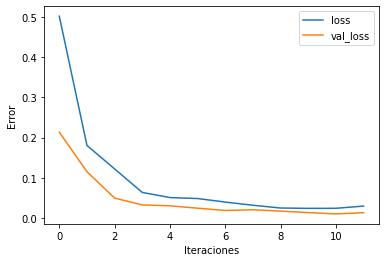

In [ ]:
#Se grafica la perdida
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()
plt.xlabel('Iteraciones')
plt.ylabel('Error')

Text(0, 0.5, 'Error')

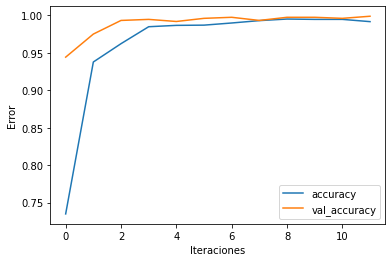

In [ ]:
#Se grafica la presición obtenida
losses[['accuracy','val_accuracy']].plot()
plt.xlabel('Iteraciones')
plt.ylabel('Error')

In [ ]:
'''
Variable que predice la probabilidad de pertener a una categoría
Recordando que solo existe una neurona de salida por ser binario
por lo que se requiere para establecer un margen
'''
pred_probability = model.predict_generator(test_set)

In [ ]:
#En caso de superar un 0.5, pasa a considerarse un 1 o pieza buena
predictions = pred_probability > 0.5

In [ ]:
#Se imprimen en pantalla una tabla resumen de los resultado
#Se indica la presición que tiene al clasificar el conjunto de test
print(classification_report(test_set.classes,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       453
           1       1.00      1.00      1.00       262

    accuracy                           1.00       715
   macro avg       1.00      1.00      1.00       715
weighted avg       1.00      1.00      1.00       715



Lo último que se realiza es la matriz de confusión, esta será la encargada de verificar el fucnionamiento de la red, para poder conocer que tan bien entrenada está, un resultado negativo sería que la red falle muchos resultados al clasificar, lo que obligaría a volver a entrenarla o modificarla para un mejor reultado

Text(69.0, 0.5, 'Predicción')

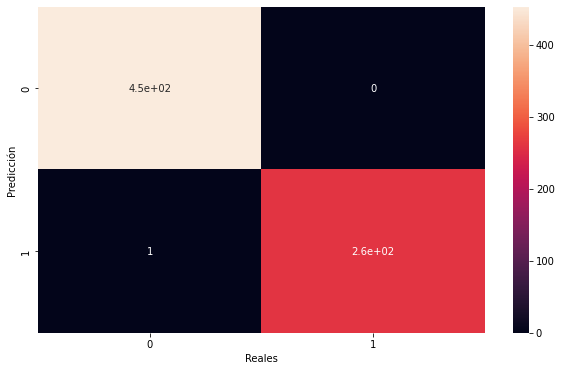

In [ ]:
#Se grafica la matriz de confusión para evaluar el funcionamiento de la red
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(test_set.classes,predictions),annot=True)
plt.xlabel("Reales")
plt.ylabel("Predicción")

Fin del código